In [ ]:
import os
import math
import pandas as pd
import numpy as np
import time
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import matplotlib
%matplotlib widget
import matplotlib.pyplot as plt 
import pylab as pl
from IPython import display
import pickle
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import pchip_interpolate, interp1d
from scipy.signal import resample, detrend, resample_poly
from operator import itemgetter

In [ ]:
# Read in source and receiver geometry files
geomcols=np.arange(8)
wellcols=np.arange(12)
CASSMGeom=pd.read_excel('/home/spri902/Collab_metadata/SigmaV_Channel_Monitoring_Rev_1.0_PetrovMod.xlsx',\
                        sheet_name='Geode',header=0,usecols=geomcols)
CASSMsrc=pd.read_excel('/home/spri902/Collab_metadata/SigmaV_Channel_Monitoring_Rev_1.0_PetrovMod.xlsx',\
                        sheet_name='CASSM_Channels',header=0,usecols=geomcols)
CASSMsrc.columns = [c.replace(' ','_') for c in CASSMsrc.columns]
# WellGeom=pd.read_excel('/home/spri902/Collab_metadata/Well_Points.xlsx',header=0,usecols=wellcols)
# %% Read in DAS data
# and to read the pickle
# df_all = pd.read_pickle('/home/spri902/EGS_Collab/4850/results/maystim/processed_DAS/lpFilter/wellPDB/maystim22_26_combined_n')
# df_r = pd.read_pickle('/home/spri902/EGS_Collab/4850/results/maystim/processed_DAS/lpFilter/wellPDB/maystim22_26_combined_r')
df_fullB = pd.read_pickle('/home/spri902/EGS_Collab/4850/results/maystim/processed_DAS/lpFilter/wellPDB/maystim22_26_combined_full')
df_fullT = pd.read_pickle('/home/spri902/EGS_Collab/4850/results/maystim/processed_DAS/lpFilter/wellPDT/maystim22_26_combined_full')
df_fullOB = pd.read_pickle('/home/spri902/EGS_Collab/4850/results/maystim/processed_DAS/lpFilter/wellOB/maystim22_26_combined_full')
df_fullOT = pd.read_pickle('/home/spri902/EGS_Collab/4850/results/maystim/processed_DAS/lpFilter/wellOT/maystim22_26_combined_full')
df_fullPST = pd.read_pickle('/home/spri902/EGS_Collab/4850/results/maystim/processed_DAS/lpFilter/wellPST/maystim22_26_combined_full')
df_fullPSB = pd.read_pickle('/home/spri902/EGS_Collab/4850/results/maystim/processed_DAS/lpFilter/wellPSB/maystim22_26_combined_full')
dasScaler = 116.0
df_fullB = df_fullB.multiply(dasScaler)
df_fullT = df_fullT.multiply(dasScaler)
df_fullOB = df_fullOB.multiply(dasScaler)
df_fullOT = df_fullOT.multiply(dasScaler)
df_fullPST = df_fullPST.multiply(dasScaler)
df_fullPSB = df_fullPSB.multiply(dasScaler)
# df_full = np.array(df_full)
df_fullB = detrend(df_fullB,axis=0,type='linear')
df_fullT = detrend(df_fullT,axis=0,type='linear')
df_fullOB = detrend(df_fullOB,axis=0,type='linear')
df_fullOT = detrend(df_fullOT,axis=0,type='linear')
df_fullPST = detrend(df_fullPST,axis=0,type='linear')
df_fullPSB = detrend(df_fullPSB,axis=0,type='linear')
# Bring in filenames for dates


In [ ]:

wn     = ['OT','OB','PST','PSB','PDB','PDT']
nfile_list = sorted(os.walk('/data1/parker/EGS_iDAS'))
nfile_list = nfile_list[1:]
#file_list = file_list[1:]
nfile_list = [group[2] for group in nfile_list]
nfile_list = [item for sublist in nfile_list for item in sublist]
# [file_list.append(f) for f in nfile_list]
fd = [name.split("_") for name in nfile_list]
fl = [fd[file][2].split(".") for file in range(len(fd))]
fl = [el[0] for el in fl]
DASdates = [datetime.strptime(d,'%y%m%d%H%M%S') for d in sorted(fl)]
# these are files that get skipped during the low pass filtering process and so the dates need to be removed 
ind2rem = [0, 90, 91, 257, 258, 1571, 1572, 3082, 3083, 5085, 5086, 5599, 5600, 5961, 5962, 7623, 7624, 8841, 8842, 9562]
# remove in reverse so that the indices remain in the correct order for removal
for index in sorted(ind2rem,reverse=True):
    del DASdates[index]
# path ='/home/spri902/EGS_Collab/4850/results/maystim/processed_DAS/lpFilter/wellPDB'
# file = 'DASdates.pkl'
# with open(os.path.join(path,file)) as f:
#     DASdates = pickle.load(f)

# chans=np.linspace(0,1727,1728).astype(int)
# ch_bot = [396, 576, 837, 982, 1150, 1329]
# PDBdown = PDBchans[0:math.trunc(len(PDBchans)/2)]
# PDBup   = np.flipud(PDBchans[math.trunc(len(PDBchans)/2)+1:])
# PDBdat  = df_all.iloc[PDBdown,:].values + df_all.iloc[PDBup,:].values

In [ ]:
# %% Read in CASSM data
directory = sorted(os.walk('/home/spri902/mayCASSM'))
CASSMdates = [datetime.strptime(d,'%Y%m%d%H%M%S') for d in sorted(directory[0][1])]
filepath9 = '/home/spri902/EGS_Collab/4850/results/maystim/processed_CASSM/single_src_rec_gathers/src9_PDBhyds_accs/'
filepath11 = '/home/spri902/EGS_Collab/4850/results/maystim/processed_CASSM/single_src_rec_gathers/src11_PSThyds_accs/'
filepath17 = '/home/spri902/EGS_Collab/4850/results/maystim/processed_CASSM/single_src_rec_gathers/src17_PDThyds_accs/'
os.chdir(filepath9)
dat9file = 'PST9data.npy'
seis9data = np.load(os.path.join(filepath9, dat9file))
ccorr9 = np.load('PST9_ccorr.npy')['arr_0']
# Read in Streching Data src9
stretchdata9 = np.load('PST9_stretch_16.npz')
dtArray9 = stretchdata9['arr_0'].T
tSamp9 = stretchdata9['arr_1']
cArray9 = stretchdata9['arr_2']
# Read in Streching Data src9
os.chdir(filepath11)
dat11file = 'PST11data.npy'
seis11data = np.load(os.path.join(filepath11, dat11file))
ccorr11 = np.load('PST11_ccorr.npy')['arr_0']
stretchdata11 = np.load('PST11_stretch_16.npz')
dtArray11 = stretchdata11['arr_0'].T
tSamp11 = stretchdata11['arr_1']
cArray11 = stretchdata11['arr_2']
# Read in Data src17
os.chdir(filepath17)
dat17file = 'PDT17data.npy'
seis17data = np.load(os.path.join(filepath17, dat17file))
ccorr17 = np.load('PDT17_ccorr.npy')['arr_0']
stretchdata17 = np.load('PDT17_stretch_16.npz')
dtArray17 = stretchdata17['arr_0'].T
tSamp17 = stretchdata17['arr_1']
cArray17 = stretchdata17['arr_2']
# Set up lines for plotting start and stop of injections
chansB=np.linspace(0,df_fullB.shape[1] - 1,df_fullB.shape[1]).astype(int)
chansT=np.linspace(0,df_fullT.shape[1] - 1,df_fullT.shape[1]).astype(int)
chansOB=np.linspace(0,df_fullOB.shape[1] - 1,df_fullOB.shape[1]).astype(int)
chansOT=np.linspace(0,df_fullOT.shape[1] - 1,df_fullOT.shape[1]).astype(int)
chansPST=np.linspace(0,df_fullPST.shape[1] - 1,df_fullPST.shape[1]).astype(int)
chansPSB=np.linspace(0,df_fullPSB.shape[1] - 1,df_fullPSB.shape[1]).astype(int)
stimbeg = [96, 224, 352, 472, 507]
stimfin = [106, 232, 368, 475, 512]
stimbegLines = itemgetter(*stimbeg)(CASSMdates)
stimfinLines = itemgetter(*stimfin)(CASSMdates)
# stimvec=[]
# [stimvec.append(np.r_[stimbeg[stim]:stimfin[stim]+1]) for stim in range(len(stimbeg))]
# stimvec=np.concatenate(stimvec).ravel().tolist()



In [ ]:
# Bring in MEQ catalog
meq = pd.read_csv('/home/spri902/EGS_Collab/4850/MEQ/MEQcat.csv',header=0,parse_dates=[11],infer_datetime_format=True)
meq.columns = meq.columns.str.replace(' ','')
dates = mdates.date2num(meq['time'])
meq['datenums'] = dates
meq = meq[(meq['time'] > pd.to_datetime('2018-05-22T00')) & (meq['time'] < pd.to_datetime('2018-05-25T23'))]


In [ ]:
# Bring in Injection data
os.chdir('/home/spri902/EGS_Collab/4850/stimflow/')
injFiles = sorted(os.listdir('/home/spri902/EGS_Collab/4850/stimflow/'))
injDat = pd.concat((pd.read_csv(f,header=1,usecols=[0,2,4,24],\
                           parse_dates = [0],infer_datetime_format=True) \
                    for f in injFiles if f.endswith('.csv')),axis=0)
injDat.rename(columns={'hh:mm:ss':'date','LPM':'QLPM','LPM.1':'TLPM','psig.9':'psig'},inplace=True)
# tmp = pd.read_csv(injFiles[3],header=1,usecols=[0,16],\
                          # parse_dates=[0],infer_datetime_format=True)
# tmp.rename(columns={'hh:mm:ss':'date','psig.2':'psig'},inplace=True)
# injDat = pd.concat((injDat,tmp),axis=0)
injDat.reset_index(drop = True,inplace = True)
injDat.set_index('date',inplace=True)
injDat = injDat.iloc[14650:]
injDat = injDat[~injDat.index.duplicated(keep='first')]

In [ ]:
cumQvol = np.cumsum(injDat.QLPM)
cumTvol = np.cumsum(injDat.TLPM)
flwRate = injDat.QLPM + injDat.TLPM
# plt.figure()
# injDat.loc[:,("QLPM")].plot(style='.',label='Cumulative Volume Quizix',legend=True)
# injDat.loc[:,("TLPM")].plot(style='.',label='Cumulative Volume TriPlex',legend=True)

In [ ]:
# %% Make new time axis
dasdnums = mdates.date2num(DASdates)
cassmdnums = mdates.date2num(CASSMdates)
CASSM9int = pchip_interpolate(cassmdnums[:-2],ccorr9[16,:-1],dasdnums)
CASSM11int = pchip_interpolate(cassmdnums[:-2],ccorr11[16,:-1],dasdnums)
CASSM17int = pchip_interpolate(cassmdnums[:-2],ccorr17[16,:-1],dasdnums)

DASintB = resample(df_fullB,len(cassmdnums[:-2]))
DASintT = resample(df_fullT,len(cassmdnums[:-2]))
DASintOB = resample(df_fullOB,len(cassmdnums[:-2]))
DASintOT = resample(df_fullOT,len(cassmdnums[:-2]))
DASintPST = resample(df_fullPST,len(cassmdnums[:-2]))
DASintPSB = resample(df_fullPSB,len(cassmdnums[:-2]))
dasd = pd.date_range(start=DASdates[0],end=DASdates[-1],periods=len(cassmdnums[:-2]))
# chans=np.linspace(0,df_full.shape[1] - 1,df_full.shape[1]).astype(int)

df_strain_intB = cumulative_trapezoid(DASintB,axis=0,initial=0)
df_strainB = cumulative_trapezoid(df_fullB,axis=0,initial=0) 
df_strain_intOB = cumulative_trapezoid(DASintOB,axis=0,initial=0)
df_strainOB = cumulative_trapezoid(df_fullOB,axis=0,initial=0)
df_strain_intOT = cumulative_trapezoid(DASintOT,axis=0,initial=0)
df_strainOT = cumulative_trapezoid(df_fullOT,axis=0,initial=0)
df_strain_intT = cumulative_trapezoid(DASintT,axis=0,initial=0)
df_strainT = cumulative_trapezoid(df_fullT,axis=0,initial=0)
df_strain_intPST = cumulative_trapezoid(DASintPST,axis=0,initial=0)
df_strainPST = cumulative_trapezoid(df_fullPST,axis=0,initial=0)
df_strain_intPSB = cumulative_trapezoid(DASintPSB,axis=0,initial=0)
df_strainPSB = cumulative_trapezoid(df_fullPSB,axis=0,initial=0)
# df_strainB = detrend(df_strainB,axis = 0,type = 'linear')
# df_strainT = detrend(df_strainT,axis = 0,type = 'linear')
# strn2dv = resample(dtArray9[473,:],len(DASint[577,1:61]))
# strn2dv = pchip_interpolate(tSamp9,dtArray[473,:],)
# strn2dv = resample(dtArray9[473,:],len(df_strain[577,:]))


In [ ]:
# Wells OB and OT
fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(12,6))

ax3=[ax3,ax3.twinx()]
# ax2[0] = injDat['psig'].plot(style='.',label='Injection Pressure',legend=True)
# ax2[1] = injDat['TLPM'].plot(secondary_y=True,color='orange',marker='o')
b1 = ax3[0].plot(injDat['psig'],'.k',label='Injection Pressure')
b2 = ax3[1].plot(flwRate,'r.',label='Flow Rate (LPM)',markersize=2)
ax3[0].set_ylabel('psig')
ax3[1].set_ylabel('Flow Rate (LPM)')
ax3[0].set_title('Injection Interval Pressure and Flow Rate')
ax3[0].set_xlabel('Date')
l9 = ax3[0].axvspan(stimbegLines[0],stimfinLines[0],alpha=0.7,color='grey',label='Injection')
l5 = ax3[0].axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
l6 = ax3[0].axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
l7 = ax3[0].axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
l8 = ax3[0].axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
lns2 = b1+b2+[l5]
lbls2 = [ln.get_label() for ln in lns2]
ax3[0].legend(lns2,lbls2,loc='lower left')
ax3[0].yaxis.label.set_color(b1[0].get_color())
ax3[1].yaxis.label.set_color(b2[0].get_color())
ax3[0].tick_params(axis='y',colors=b1[0].get_color())
ax3[1].tick_params(axis='y',colors=b2[0].get_color())

ax1 = [ax1,ax1.twinx()]
a1=ax1[0].plot(DASdates,df_fullOB[:,30],'k',label='Strain Rate')
a2=ax1[1].plot(DASdates,df_strainOB[:,30],'g',label='Strain')
# a1=ax1[0].plot(DASdates,df_fullB.iloc[:,30],'k',label='Strain Rate')
# a2=ax1[1].plot(DASdates,df_strainB[:,30],'g',label='Strain')
l0 = ax1[0].axvspan(stimbegLines[0],stimfinLines[0],alpha=0.7,color='grey',label='Injection')
l1 = ax1[0].axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
l2 = ax1[0].axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
l3 = ax1[0].axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
l4 = ax1[0].axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
lns =  a1+a2+[l1]
lbls= [ln.get_label() for ln in  lns]
ax1[0].legend(lns,lbls,loc='lower left')
plt.title('Well OB DAS Strain-Rate and Strain')
# ax1[0].set_xlabel('Date')
ax1[0].set_ylabel('Strain-Rate')
ax1[1].set_ylabel('Strain')
ax1[0].yaxis.label.set_color(a1[0].get_color())
ax1[1].yaxis.label.set_color(a2[0].get_color())
ax1[0].tick_params(axis='y',colors=a1[0].get_color())
ax1[1].tick_params(axis='y',colors=a2[0].get_color())

ax2 = [ax2,ax2.twinx()]
a1=ax2[0].plot(DASdates,df_fullOT[:,29],'k',label='Strain Rate')
a2=ax2[1].plot(DASdates,df_strainOT[:,29],'g',label='Strain')
# a1=ax2[0].plot(DASdates,df_fullT.iloc[:,29],'k',label='Strain Rate')
# a2=ax2[1].plot(DASdates,df_strainT[:,29],'g',label='Strain')
l0 = ax2[0].axvspan(stimbegLines[0],stimfinLines[0],alpha=0.7,color='grey',label='Injection')
l1 = ax2[0].axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
l2 = ax2[0].axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
l3 = ax2[0].axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
l4 = ax2[0].axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
lns =  a1+a2+[l0]
lbls= [ln.get_label() for ln in  lns]
ax2[0].legend(lns,lbls,loc='lower left')
plt.title('Well OT DAS Strain-Rate and Strain')
# ax2[0].set_xlabel('Date')
ax2[0].set_ylabel('Strain-Rate')
ax2[1].set_ylabel('Strain')
ax2[0].yaxis.label.set_color(a1[0].get_color())
ax2[1].yaxis.label.set_color(a2[0].get_color())
ax2[0].tick_params(axis='y',colors=a1[0].get_color())
ax2[1].tick_params(axis='y',colors=a2[0].get_color())

In [ ]:
# Wells PSB and PST
# fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(12,6))
fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(12,6))
ax3=[ax3,ax3.twinx()]
# ax2[0] = injDat['psig'].plot(style='.',label='Injection Pressure',legend=True)
# ax2[1] = injDat['TLPM'].plot(secondary_y=True,color='orange',marker='o')
b1 = ax3[0].plot(injDat['psig'],'.k',label='Injection Pressure')
b2 = ax3[1].plot(flwRate,'r.',label='Flow Rate (LPM)',markersize=2)
ax3[0].set_ylabel('psig')
ax3[1].set_ylabel('Flow Rate (LPM)')
ax3[0].set_title('Injection Interval Pressure and Flow Rate')
ax3[0].set_xlabel('Date')
l9 = ax3[0].axvspan(stimbegLines[0],stimfinLines[0],alpha=0.7,color='grey',label='Injection')
l5 = ax3[0].axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
l6 = ax3[0].axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
l7 = ax3[0].axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
l8 = ax3[0].axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
lns2 = b1+b2+[l5]
lbls2 = [ln.get_label() for ln in lns2]
ax3[0].legend(lns2,lbls2,loc='lower left')
ax3[0].yaxis.label.set_color(b1[0].get_color())
ax3[1].yaxis.label.set_color(b2[0].get_color())
ax3[0].tick_params(axis='y',colors=b1[0].get_color())
ax3[1].tick_params(axis='y',colors=b2[0].get_color())

ax1 = [ax1,ax1.twinx()]
a1=ax1[0].plot(DASdates,df_fullPST[:,24],'k',label='Strain Rate')
a2=ax1[1].plot(DASdates,df_strainPST[:,24],'g',label='Strain')
# a1=ax1[0].plot(DASdates,df_fullB.iloc[:,30],'k',label='Strain Rate')
# a2=ax1[1].plot(DASdates,df_strainB[:,30],'g',label='Strain')
l0 = ax1[0].axvspan(stimbegLines[0],stimfinLines[0],alpha=0.7,color='grey',label='Injection')
l1 = ax1[0].axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
l2 = ax1[0].axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
l3 = ax1[0].axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
l4 = ax1[0].axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
lns =  a1+a2+[l1]
lbls= [ln.get_label() for ln in  lns]
ax1[0].legend(lns,lbls,loc='lower left')
plt.title('Well PST DAS Strain-Rate and Strain')
# ax1[0].set_xlabel('Date')
ax1[0].set_ylabel('Strain-Rate')
ax1[1].set_ylabel('Strain')
ax1[0].yaxis.label.set_color(a1[0].get_color())
ax1[1].yaxis.label.set_color(a2[0].get_color())
ax1[0].tick_params(axis='y',colors=a1[0].get_color())
ax1[1].tick_params(axis='y',colors=a2[0].get_color())

ax2 = [ax2,ax2.twinx()]
a1=ax2[0].plot(DASdates,df_fullPSB[:,30],'k',label='Strain Rate')
a2=ax2[1].plot(DASdates,df_strainPSB[:,30],'g',label='Strain')
# a1=ax2[0].plot(DASdates,df_fullT.iloc[:,29],'k',label='Strain Rate')
# a2=ax2[1].plot(DASdates,df_strainT[:,29],'g',label='Strain')
l0 = ax2[0].axvspan(stimbegLines[0],stimfinLines[0],alpha=0.7,color='grey',label='Injection')
l1 = ax2[0].axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
l2 = ax2[0].axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
l3 = ax2[0].axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
l4 = ax2[0].axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
lns =  a1+a2+[l0]
lbls= [ln.get_label() for ln in  lns]
ax2[0].legend(lns,lbls,loc='lower left')
plt.title('Well PSB DAS Strain-Rate and Strain')
# ax2[0].set_xlabel('Date')
ax2[0].set_ylabel('Strain-Rate')
ax2[1].set_ylabel('Strain')
ax2[0].yaxis.label.set_color(a1[0].get_color())
ax2[1].yaxis.label.set_color(a2[0].get_color())
ax2[0].tick_params(axis='y',colors=a1[0].get_color())
ax2[1].tick_params(axis='y',colors=a2[0].get_color())

In [ ]:
# Wells  PDB and PDT
fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True,figsize=(12,6))
ax3=[ax3,ax3.twinx()]
# ax2[0] = injDat['psig'].plot(style='.',label='Injection Pressure',legend=True)
# ax2[1] = injDat['TLPM'].plot(secondary_y=True,color='orange',marker='o')
b1 = ax3[0].plot(injDat['psig'],'.k',label='Injection Pressure')
b2 = ax3[1].plot(flwRate,'r.',label='Flow Rate (LPM)',markersize=2)
ax3[0].set_ylabel('psig')
ax3[1].set_ylabel('Flow Rate (LPM)')
ax3[0].set_title('Injection Interval Pressure and Flow Rate')
ax3[0].set_xlabel('Date')
l9 = ax3[0].axvspan(stimbegLines[0],stimfinLines[0],alpha=0.7,color='grey',label='Injection')
l5 = ax3[0].axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
l6 = ax3[0].axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
l7 = ax3[0].axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
l8 = ax3[0].axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
lns2 = b1+b2+[l5]
lbls2 = [ln.get_label() for ln in lns2]
ax3[0].legend(lns2,lbls2,loc='lower left')
ax3[0].yaxis.label.set_color(b1[0].get_color())
ax3[1].yaxis.label.set_color(b2[0].get_color())
ax3[0].tick_params(axis='y',colors=b1[0].get_color())
ax3[1].tick_params(axis='y',colors=b2[0].get_color())

ax1 = [ax1,ax1.twinx()]
a1=ax1[0].plot(DASdates,df_fullB[:,30],'k',label='Strain Rate')
a2=ax1[1].plot(DASdates,df_strainB[:,30],'g',label='Strain')
# a1=ax1[0].plot(DASdates,df_fullB.iloc[:,30],'k',label='Strain Rate')
# a2=ax1[1].plot(DASdates,df_strainB[:,30],'g',label='Strain')
l0 = ax1[0].axvspan(stimbegLines[0],stimfinLines[0],alpha=0.7,color='grey',label='Injection')
l1 = ax1[0].axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
l2 = ax1[0].axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
l3 = ax1[0].axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
l4 = ax1[0].axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
lns =  a1+a2+[l1]
lbls= [ln.get_label() for ln in  lns]
ax1[0].legend(lns,lbls,loc='lower left')
plt.title('Well PDB DAS Strain-Rate and Strain')
# ax1[0].set_xlabel('Date')
ax1[0].set_ylabel('Strain-Rate')
ax1[1].set_ylabel('Strain')
ax1[0].yaxis.label.set_color(a1[0].get_color())
ax1[1].yaxis.label.set_color(a2[0].get_color())
ax1[0].tick_params(axis='y',colors=a1[0].get_color())
ax1[1].tick_params(axis='y',colors=a2[0].get_color())

ax2 = [ax2,ax2.twinx()]
a1=ax2[0].plot(DASdates,df_fullT[:,29],'k',label='Strain Rate')
a2=ax2[1].plot(DASdates,df_strainT[:,29],'g',label='Strain')
# a1=ax2[0].plot(DASdates,df_fullT.iloc[:,29],'k',label='Strain Rate')
# a2=ax2[1].plot(DASdates,df_strainT[:,29],'g',label='Strain')
l0 = ax2[0].axvspan(stimbegLines[0],stimfinLines[0],alpha=0.7,color='grey',label='Injection')
l1 = ax2[0].axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
l2 = ax2[0].axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
l3 = ax2[0].axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
l4 = ax2[0].axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
lns =  a1+a2+[l0]
lbls= [ln.get_label() for ln in  lns]
ax2[0].legend(lns,lbls,loc='lower left')
plt.title('Well PDT DAS Strain-Rate and Strain')
# ax2[0].set_xlabel('Date')
ax2[0].set_ylabel('Strain-Rate')
ax2[1].set_ylabel('Strain')
ax2[0].yaxis.label.set_color(a1[0].get_color())
ax2[1].yaxis.label.set_color(a2[0].get_color())
ax2[0].tick_params(axis='y',colors=a1[0].get_color())
ax2[1].tick_params(axis='y',colors=a2[0].get_color())


In [ ]:
# %% Make plots of DAS with CASSM 9 src
fig,ax, = plt.subplots(3, figsize=(12,6),sharex=True,sharey=True)
plt.suptitle('PDB DAS Strain Rate and CASSM Accelerometers')
ax0 = ax[0].twinx()
ax1 = ax[1].twinx()
ax2 = ax[2].twinx()


p1=ax[0].plot(dasd,DASintB[:,30],label='Well PDB DAS strain rate')
p2=ax0.plot(CASSMdates[1:],ccorr9[16,:],label='Zero-Lag Corrcoeff for PDB ',color='magenta')
l1 = ax[0].axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
l2 = ax[0].axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
l3 = ax[0].axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
l4 = ax[0].axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
ax0.set_ylabel('Corr Coef')
ax[0].set_ylabel('DAS Strain Rate')
ax0.set_ylim([0.1,1])
ax0.set_title('CASSM Receiver 9')


p1=ax[1].plot(dasd,DASintB[:,30],label='Well PDB DAS strain rate')
p2=ax1.plot(CASSMdates[1:],ccorr11[16,:],label='Zero-Lag Corrcoeff for PDB ',color='magenta')
l1 = ax[1].axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
l2 = ax[1].axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
l3 = ax[1].axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
l4 = ax[1].axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
ax1.set_ylabel('Corr Coef')
ax[1].set_ylabel('DAS Strain Rate')
ax1.set_ylim([0.1,1])
ax1.set_title(('CASSM Receiver 11'))


p1=ax[2].plot(dasd,DASintB[:,30],label='Well PDB DAS strain rate')
p2=ax2.plot(CASSMdates[1:],ccorr17[16,:],label='Zero-Lag Corrcoeff for PDB ',color='magenta')
l1 = ax[2].axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
l2 = ax[2].axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
l3 = ax[2].axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
l4 = ax[2].axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
ax2.set_ylabel('Corr Coef')
ax[2].set_xlabel('Experiment Date')
ax[2].set_ylabel('DAS Strain Rate')
ax2.set_ylim([0.1,1])
ax2.set_title('CASSM Receiver 17')

lns = p1+p2+[l1]
labls = [l.get_label() for l in lns]
ax2.legend(lns,labls, loc='lower right')



In [ ]:
fig,ax, = plt.subplots(3, figsize=(12,6),sharex=True,sharey=True)
plt.suptitle('PDT DAS Strain Rate and CASSM Accelerometers')
ax0 = ax[0].twinx()
ax1 = ax[1].twinx()
ax2 = ax[2].twinx()


p1=ax[0].plot(dasd,DASintT[:,29],label='Well PDT DAS strain rate')
p2=ax0.plot(CASSMdates[1:],ccorr9[16,:],label='Zero-Lag Corrcoeff for PDB ',color='magenta')
l1 = ax[0].axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
l2 = ax[0].axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
l3 = ax[0].axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
l4 = ax[0].axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
ax0.set_ylabel('Corr Coef')
ax[0].set_ylabel('DAS Strain Rate')
ax0.set_ylim([0.1,1])
ax0.set_title('CASSM Receiver 9')


p1=ax[1].plot(dasd,DASintT[:,29],label='Well PDT DAS strain rate')
p2=ax1.plot(CASSMdates[1:],ccorr11[16,:],label='Zero-Lag Corrcoeff for PDB ',color='magenta')
l1 = ax[1].axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
l2 = ax[1].axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
l3 = ax[1].axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
l4 = ax[1].axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
ax1.set_ylabel('Corr Coef')
ax[1].set_ylabel('DAS Strain Rate')
ax1.set_ylim([0.1,1])
ax1.set_title(('CASSM Receiver 11'))


p1=ax[2].plot(dasd,DASintT[:,29],label='Well PDT DAS strain rate')
p2=ax2.plot(CASSMdates[1:],ccorr17[16,:],label='Zero-Lag Corrcoeff for PDB ',color='magenta')
l1 = ax[2].axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
l2 = ax[2].axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
l3 = ax[2].axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
l4 = ax[2].axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
ax2.set_ylabel('Corr Coef')
ax[2].set_xlabel('Experiment Date')
ax[2].set_ylabel('DAS Strain Rate')
ax2.set_ylim([0.1,1])
ax2.set_title('CASSM Receiver 17')

lns = p1+p2+[l1]
labls = [l.get_label() for l in lns]
ax2.legend(lns,labls, loc='lower right')

In [ ]:

# Upsampled CASSM src9 corrcoeffs files to DAS files
fig,ax = plt.subplots(figsize=(8,8))
# plt.yscale('log')
# plt.xscale('log')
sc = ax.scatter(CASSM9int,df_fullB[:,30],c=dasdnums,marker='.',cmap='cool')
ax.set_xlim(1,0.1)
loc = mdates.AutoDateLocator()
fig.colorbar(sc,ticks=loc,format=mdates.AutoDateFormatter(loc))
plt.xlabel('CorrCoeff values')
plt.ylabel('DAS Strain Rate')
plt.title('Well PDB DAS strain rate vs Source 9 CorrCoeff values')



In [ ]:
# Upsampled CASSM src11 corrcoeffs files to DAS files
fig,ax = plt.subplots(figsize=(8,8))
# plt.yscale('log')
# plt.xscale('log')
sc = ax.scatter(CASSM11int,df_fullB[:,30],c=dasdnums,marker='.',cmap='cool')
ax.set_xlim(1,0.1)
loc = mdates.AutoDateLocator()
fig.colorbar(sc,ticks=loc,format=mdates.AutoDateFormatter(loc))
plt.xlabel('CorrCoeff values')
plt.ylabel('DAS Strain Rate')
plt.title('Well PDB DAS strain rate vs Source 11 CorrCoeff values')

In [ ]:
# %% plot image of entire well of DAS Real DAS time strain rate data
fig, ax = plt.subplots(figsize=(8,8))
# vm=np.nanpercentile(df_fullB,99)
img = ax.pcolormesh(DASdates,chansOT,df_fullOT.T,cmap='RdBu_r',vmin=-20,vmax=20)
# img = ax.pcolormesh(DASdates,chansB,df_fullB.T,cmap='RdBu')
plt.gca().invert_yaxis()
ax.xaxis_date()
plt.colorbar(img,orientation="horizontal",label='Nanostrain Rate (nm/m)/s ')
plt.title('DAS Strain Rate All channels in well OT')
plt.ylabel('Channel Number')

In [ ]:
# %% plot image of entire well of DAS Real DAS time strain rate data
fig, ax = plt.subplots(figsize=(8,8))
# vm=np.nanpercentile(df_fullB,99)
img = ax.pcolormesh(DASdates,chansOB,df_fullOB.T,cmap='RdBu_r',vmin=-20,vmax=20)
# img = ax.pcolormesh(DASdates,chansB,df_fullB.T,cmap='RdBu')
plt.gca().invert_yaxis()
ax.xaxis_date()
plt.colorbar(img,orientation="horizontal",label='Nanostrain Rate (nm/m)/s ')
plt.title('DAS Strain Rate All channels in well OB')
plt.ylabel('Channel Number')

In [ ]:
# %% plot image of entire well of DAS Real DAS time strain rate data
fig, ax = plt.subplots(figsize=(8,8))
# vm=np.nanpercentile(df_fullB,99)
img = ax.pcolormesh(DASdates,chansPST,df_fullPST.T,cmap='RdBu_r',vmin=-20,vmax=20)
# img = ax.pcolormesh(DASdates,chansB,df_fullB.T,cmap='RdBu')
plt.gca().invert_yaxis()
ax.xaxis_date()
plt.colorbar(img,orientation="horizontal",label='Nanostrain Rate (nm/m)/s ')
plt.title('DAS Strain Rate All channels in well PST')
plt.ylabel('Channel Number')

In [ ]:
# %% plot image of entire well of DAS Real DAS time strain rate data
fig, ax = plt.subplots(figsize=(8,8))
# vm=np.nanpercentile(df_fullB,99)
img = ax.pcolormesh(DASdates,chansPSB,df_fullPSB.T,cmap='RdBu_r',vmin=-20,vmax=20)
# img = ax.pcolormesh(DASdates,chansB,df_fullB.T,cmap='RdBu')
plt.gca().invert_yaxis()
ax.xaxis_date()
plt.colorbar(img,orientation="horizontal",label='Nanostrain Rate (nm/m)/s ')
plt.title('DAS Strain Rate All channels in well PST')
plt.ylabel('Channel Number')

In [ ]:
# %% plot image of entire well of DAS Real DAS time strain rate data
fig, ax = plt.subplots(figsize=(8,8))
# vm=np.nanpercentile(df_fullB,99)
img = ax.pcolormesh(DASdates,chansB,df_fullB.T,cmap='RdBu_r',vmin=-20,vmax=20)
# img = ax.pcolormesh(DASdates,chansB,df_fullB.T,cmap='RdBu')
plt.gca().invert_yaxis()
ax.xaxis_date()
plt.colorbar(img,orientation="horizontal",label='Nanostrain Rate (nm/m)/s ')
plt.title('DAS Strain Rate All channels in well PDB')
plt.ylabel('Channel Number')

In [ ]:
# %% plot image of entire well of DAS Real DAS time strain rate data
fig, ax = plt.subplots(figsize=(8,8))
# vm=np.nanpercentile(df_fullB,99)
img = ax.pcolormesh(DASdates,chansT,df_fullT.T,cmap='RdBu_r',vmin=-20,vmax=20)
# img = ax.pcolormesh(DASdates,chansB,df_fullB.T,cmap='RdBu')
plt.gca().invert_yaxis()
ax.xaxis_date()
plt.colorbar(img,orientation="horizontal",label='Nanostrain Rate (nm/m)/s ')
plt.title('DAS Strain Rate All channels in well PDT')
plt.ylabel('Channel Number')

In [ ]:
# Upsampled CASSM src9 corrcoeffs files to DAS files
fig,ax = plt.subplots(figsize=(8,8))
# plt.yscale('log')
# plt.xscale('log')
sc = ax.scatter(CASSM9int,df_fullT[:,29],c=dasdnums,marker='.',cmap='cool')
ax.set_xlim(1,0.1)
loc = mdates.AutoDateLocator()
fig.colorbar(sc,ticks=loc,format=mdates.AutoDateFormatter(loc))
plt.xlabel('CorrCoeff values')
plt.ylabel('DAS Strain Rate')
plt.title('Well PDT DAS strain rate vs Source 9 CorrCoeff values')



In [ ]:
# Upsampled CASSM src11 corrcoeffs files to DAS files
fig,ax = plt.subplots(figsize=(8,8))
# plt.yscale('log')
# plt.xscale('log')
sc = ax.scatter(CASSM11int,df_fullT[:,29],c=dasdnums,marker='.',cmap='cool')
ax.set_xlim(1,0.1)
loc = mdates.AutoDateLocator()
fig.colorbar(sc,ticks=loc,format=mdates.AutoDateFormatter(loc))
plt.xlabel('CorrCoeff values')
plt.ylabel('DAS Strain Rate')
plt.title('Well PDT DAS strain rate vs Source 11 CorrCoeff values')

In [ ]:
# %% plot image of entire well of DAS Real DAS time strain rate data
fig, ax = plt.subplots(figsize=(8,8))
vm=np.nanpercentile(df_fullB,99)
img = ax.pcolormesh(DASdates,chansB,df_fullB.T,cmap='RdBu',vmin=-20,vmax=20)
plt.gca().invert_yaxis()
ax.xaxis_date()
plt.colorbar(img,orientation="horizontal",label='Nanostrain Rate (nm/m)/s ')
plt.title('DAS Strain Rate All channels in well PDT')
plt.ylabel('Channel Number')

In [ ]:
# %% plot image of entire well of DAS strain rate data
fig, ax = plt.subplots(figsize=(8,8))
vm=np.nanpercentile(DASintB,99)
img = ax.pcolormesh(dasd,chansB,DASintB.T,cmap='RdBu',vmin=-vm,vmax=vm)
# l1 = ax.plot(dasd,DASintB[:,30],color='black')
# img = ax.pcolormesh(dasd,chansB,DASintB.T,cmap='RdBu')
plt.gca().invert_yaxis()
ax.xaxis_date()
plt.colorbar(img,orientation="horizontal",label='Nanostrain Rate (nm/m)/s ')
plt.title('Resampled to CASSM Time Strain Rate Well PDB')
plt.ylabel('Channel Number')



In [ ]:
# %% plot image of entire well of DAS strain rate data
fig, ax = plt.subplots(figsize=(8,8))
vm=np.nanpercentile(DASintT,99)
img = ax.pcolormesh(dasd,chansT,DASintT.T,cmap='RdBu',vmin=-vm,vmax=vm)
plt.gca().invert_yaxis()
ax.xaxis_date()
plt.colorbar(img,orientation="horizontal",label='Nanostrain Rate (nm/m)/s ')
plt.title('Resampled to CASSM Time Strain Rate Well PDT')
plt.ylabel('Channel Number')

In [ ]:
# %% plot image of entire well of DAS strain  data
# fig, ax = plt.subplots(figsize=(8,8))
# vm=np.nanpercentile(df_strain,99)
# img = ax.pcolormesh(DASdates,chans,df_strain.T,cmap='RdBu',vmin=-vm,vmax=vm)
# plt.gca().invert_yaxis()
# ax.xaxis_date()
# plt.colorbar(img,orientation="horizontal",label='nanostrain')
# plt.title('DAS Strain  All channels in well PDB')

Text(0.5, 0, 'Date')

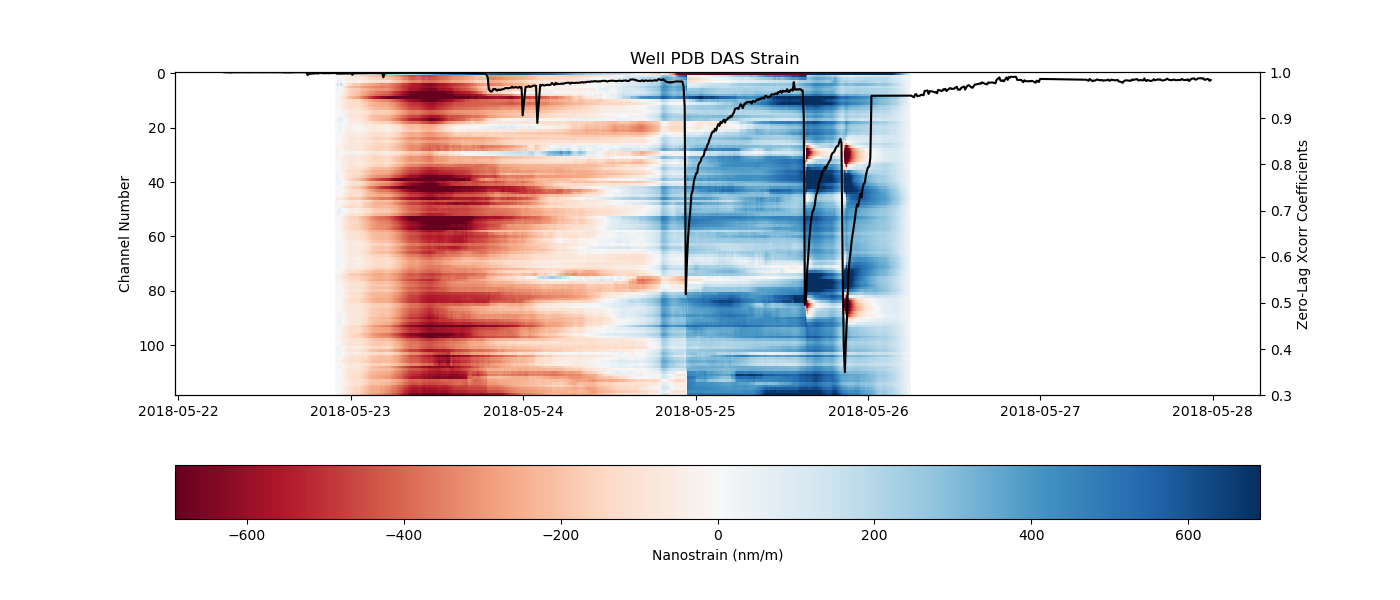

In [11]:
# cassm source 9
fig, ax = plt.subplots(figsize=(14,6))
ax2=ax.twinx()
vm=np.nanpercentile(df_strainB,99)
# if vm < 0:
#     img=ax.pcolormesh(DASdates,chans,df_full.T,cmap='RdBu',vmin=2*vm,vmax=vm+abs(vm))
# if vm > 0:
#     img=ax.pcolormesh(DASdates,chans,df_full.T,cmap='RdBu',vmin=vm/2,vmax=vm*2)
img = ax.pcolormesh(DASdates,chansB,df_strainB.T,cmap='RdBu',vmin=-vm,vmax=vm)
ax.invert_yaxis()
ax.xaxis_date()
ax.set_ylabel('Channel Number')
# l1 = ax.axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
# l2 = ax.axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
# l3 = ax.axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
# l4 = ax.axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
p2=ax2.plot(CASSMdates[1:],ccorr9[16,:],label='Zero-Lag Corrcoeff for PDB ',color='black')
ax2.set_ylim([0.3,1])
p3=ax.plot(meq.datenums[506:],30*np.ones(len(meq[506:])),'*m')
plt.colorbar(img,orientation="horizontal",label='Nanostrain (nm/m)')
plt.title('Well PDB DAS Strain ')
plt.ylabel('Zero-Lag Xcorr Coefficients')
plt.xlabel('Date')

Text(0.5, 0, 'Date')

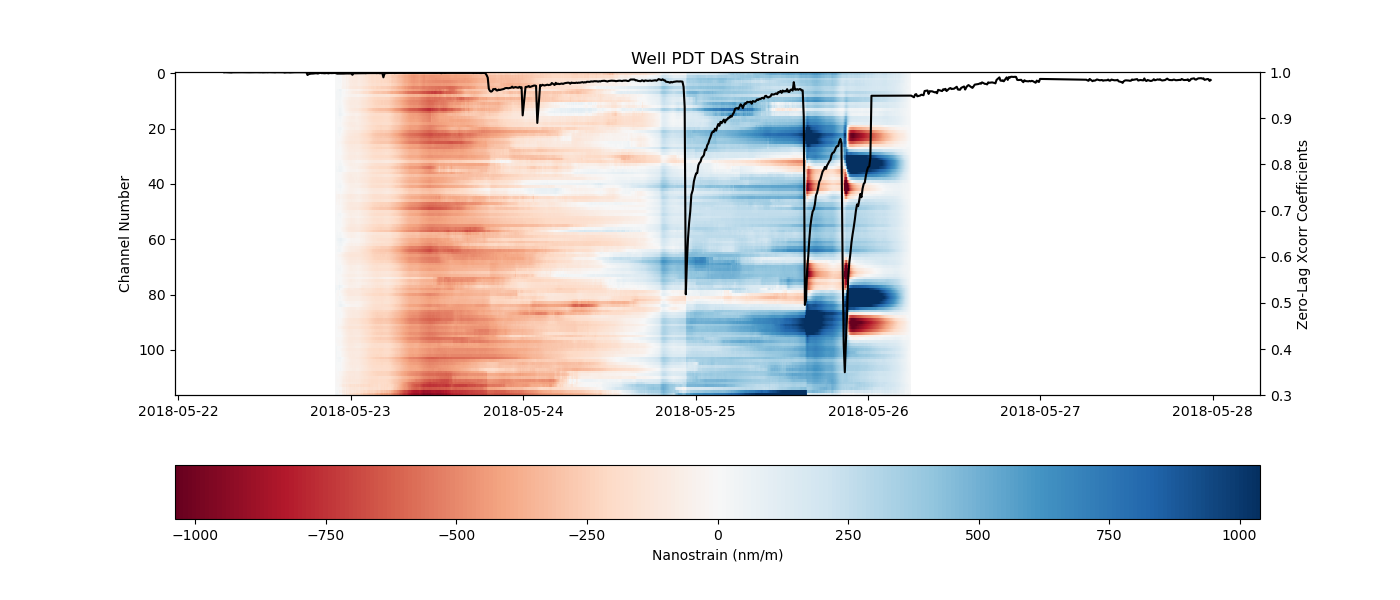

In [10]:
# cassm source 9
fig, ax = plt.subplots(figsize=(14,6))
ax2=ax.twinx()
vm=np.nanpercentile(df_strainT,99)
# if vm < 0:
#     img=ax.pcolormesh(DASdates,chans,df_full.T,cmap='RdBu',vmin=2*vm,vmax=vm+abs(vm))
# if vm > 0:
#     img=ax.pcolormesh(DASdates,chans,df_full.T,cmap='RdBu',vmin=vm/2,vmax=vm*2)
img = ax.pcolormesh(DASdates,chansT,df_strainT.T,cmap='RdBu',vmin=-vm,vmax=vm)
ax.invert_yaxis()
ax.xaxis_date()
ax.set_ylabel('Channel Number')
# l1 = ax.axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
# l2 = ax.axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
# l3 = ax.axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
# l4 = ax.axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
p2=ax2.plot(CASSMdates[1:],ccorr9[16,:],label='Zero-Lag Corrcoeff for PDB ',color='black')
ax2.set_ylim([0.3,1])
p3=ax.plot(meq.datenums[506:],30*np.ones(len(meq[506:])),'*m')
plt.colorbar(img,orientation="horizontal",label='Nanostrain (nm/m)')
plt.title('Well PDT DAS Strain ')
plt.ylabel('Zero-Lag Xcorr Coefficients')
plt.xlabel('Date')

In [ ]:
# cassm source 11 
fig, ax = plt.subplots(figsize=(14,6))
ax2=ax.twinx()

vm=np.nanpercentile(df_strainB,99)
# if vm < 0:
#     img=ax.pcolormesh(DASdates,chans,df_full.T,cmap='RdBu',vmin=2*vm,vmax=vm+abs(vm))
# if vm > 0:
#     img=ax.pcolormesh(DASdates,chans,df_full.T,cmap='RdBu',vmin=vm/2,vmax=vm*2)
img = ax.pcolormesh(DASdates,chansB,df_strainB.T,cmap='RdBu',vmin=-vm,vmax=vm)
ax.invert_yaxis()
ax.xaxis_date()
# l1 = ax.axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
# l2 = ax.axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
# l3 = ax.axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
# l4 = ax.axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
p2=ax2.plot(CASSMdates[1:],ccorr11[16,:],label='Zero-Lag Corrcoeff for PDB ',color='black')
ax2.set_ylim([0.1,1])
p3=ax.plot(meq.datenums[506:],30*np.ones(len(meq[506:])),'*m')
plt.colorbar(img,orientation="horizontal",label='Nanostrain (nm/m) ')
plt.title('Well PDB DAS Strain ')
plt.ylabel('Channel Number')
plt.xlabel('Date')



In [ ]:
# cassm source 11 
fig, ax = plt.subplots(figsize=(14,6))
ax2=ax.twinx()

vm=np.nanpercentile(df_strainT,99)
# if vm < 0:
#     img=ax.pcolormesh(DASdates,chans,df_full.T,cmap='RdBu',vmin=2*vm,vmax=vm+abs(vm))
# if vm > 0:
#     img=ax.pcolormesh(DASdates,chans,df_full.T,cmap='RdBu',vmin=vm/2,vmax=vm*2)
img = ax.pcolormesh(DASdates,chansT,df_strainT.T,cmap='RdBu',vmin=-vm,vmax=vm)
ax.invert_yaxis()
ax.xaxis_date()
# l1 = ax.axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
# l2 = ax.axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
# l3 = ax.axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
# l4 = ax.axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
p2=ax2.plot(CASSMdates[1:],ccorr11[16,:],label='Zero-Lag Corrcoeff for PDB ',color='black')
ax2.set_ylim([0.1,1])
p3=ax.plot(meq.datenums[506:],29*np.ones(len(meq[506:])),'*m')
plt.colorbar(img,orientation="horizontal",label='Nanostrain (nm/m) ')
plt.title('Well PDT DAS Strain ')
plt.ylabel('Channel Number')
plt.xlabel('Date')


In [ ]:
# cassm source 17
# fig, ax = plt.subplots(figsize=(14,6))
# ax2=ax.twinx()
# vm=np.nanpercentile(df_strain,99)
# # if vm < 0:
# #     img=ax.pcolormesh(DASdates,chans,df_full.T,cmap='RdBu',vmin=2*vm,vmax=vm+abs(vm))
# # if vm > 0:
# #     img=ax.pcolormesh(DASdates,chans,df_full.T,cmap='RdBu',vmin=vm/2,vmax=vm*2)
# img = ax.pcolormesh(dasd,chans,df_strain.T,cmap='RdBu',vmin=-vm,vmax=vm)
# ax.invert_yaxis()
# ax.xaxis_date()
# # l1 = ax.axvspan(stimbegLines[1],stimfinLines[1],alpha=0.7,color='grey',label='Injection')
# # l2 = ax.axvspan(stimbegLines[2],stimfinLines[2],alpha=0.7,color='grey',label='Injection')
# # l3 = ax.axvspan(stimbegLines[3],stimfinLines[3],alpha=0.7,color='grey',label='Injection')
# # l4 = ax.axvspan(stimbegLines[4],stimfinLines[4],alpha=0.7,color='grey',label='Injection')
# p2=ax2.plot(CASSMdates[1:],ccorr17[16,:],label='Zero-Lag Corrcoeff for PDB ',color='black')
# ax2.set_ylim([0.1,1])
# plt.colorbar(img,orientation="horizontal",label='Nanostrain')
# plt.title('Well PDB DAS Strain (nm/m) ')
# plt.ylabel('Channel Number')
# plt.xlabel('Date')

In [ ]:
tSamp = tSamp11.reshape(-1)
fig, (ax,ax1) = plt.subplots(2,1,sharex=True,figsize=(12,8))
fig.subplots_adjust(right=0.75)
ax1 = [ax1,ax1.twinx()]
ax1[1] = injDat.loc[:,("psig")].plot()
a2 = ax1[0].plot(flwRate,'r.',label='Flow Rate (LPM)', markersize=2)
ax1[0].set_ylabel('Flow Rate (LPM)')
ax1[1].set_ylabel('Injection Pressure (psig)')
# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx()]
img=axes[0].pcolormesh(CASSMdates[1:],tSamp11,np.array(dtArray11)*100,cmap='RdBu')
plt.gca().invert_yaxis
axes[0].xaxis_date()


plt.gcf().autofmt_xdate()
plt.title(f'Trace Streching and Strain Rate for Source {dat11file}')
axes[0].set_xlabel('Experiment Date')
axes[0].set_ylabel('Trace Time')
axes[0].set_ylim([0.039,0.0025])

l1=axes[1].plot(dasd,DASintB[:,30],color='black')

axes[1].set_ylabel('Strain Rate')

cbar=plt.colorbar(img, orientation='horizontal',pad=0.2)
cbar.set_label('dV -> Velocity Change (%)')



In [ ]:
tSamp = tSamp11.reshape(-1)
fig, (ax,ax1) = plt.subplots(2,1,sharex=True,figsize=(12,8))
fig.subplots_adjust(hspace=0.1)
ax1 = [ax1,ax1.twinx()]
b1 = ax1[0].plot(injDat['psig'],'.k',label='Injection Pressure')
b2 = ax1[1].plot(flwRate,'r.',label='Flow Rate (LPM)',markersize=2)
ax1[1].set_ylabel('Flow Rate (LPM)')
ax1[0].set_ylabel('Injection Pressure (psig)')
ax1[0].set_xlabel('Date')
ax1[1].yaxis.label.set_color(b1[0].get_color())
ax1[0].yaxis.label.set_color(b2[0].get_color())
ax1[1].tick_params(axis='y',colors=b1[0].get_color())
ax1[0].tick_params(axis='y',colors=b2[0].get_color())
i0 = ax1[1].axvspan(stimbegLines[0],stimfinLines[0],alpha=0.2,color='grey',label='Injection')
i1 = ax1[1].axvspan(stimbegLines[1],stimfinLines[1],alpha=0.2,color='grey',label='Injection')
i2 = ax1[1].axvspan(stimbegLines[2],stimfinLines[2],alpha=0.2,color='grey',label='Injection')
i3 = ax1[1].axvspan(stimbegLines[3],stimfinLines[3],alpha=0.2,color='grey',label='Injection')
i4 = ax1[1].axvspan(stimbegLines[4],stimfinLines[4],alpha=0.2,color='grey',label='Injection')
lns2 = b1+b2+[i0]
lbls2 = [ln.get_label() for ln in lns2]
ax1[0].legend(lns2,lbls2,loc='lower right')

ax = [ax,ax.twinx()]
img=ax[0].pcolormesh(CASSMdates[1:],tSamp11,np.array(dtArray11)*100,cmap='RdBu',vmin=-25,vmax=25)
plt.gca().invert_yaxis
ax[0].xaxis_date()
plt.gcf().autofmt_xdate()
plt.title(f'Trace Streching and Strain Rate for Source PST 11')
ax[0].set_ylabel('Trace Time')
ax[0].set_ylim([0.035,0.003])
l1=ax[1].plot(dasd,DASintB[:,30],label='DAS 30m',color='green',alpha=0.3)
l2=ax[1].plot(dasd,DASintB[:,40],label='DAS 40m',color='magenta',alpha=0.3)
i0 = ax[1].axvspan(stimbegLines[0],stimfinLines[0],alpha=0.2,color='grey',label='Injection')
i1 = ax[1].axvspan(stimbegLines[1],stimfinLines[1],alpha=0.2,color='grey',label='Injection')
i2 = ax[1].axvspan(stimbegLines[2],stimfinLines[2],alpha=0.2,color='grey',label='Injection')
i3 = ax[1].axvspan(stimbegLines[3],stimfinLines[3],alpha=0.2,color='grey',label='Injection')
i4 = ax[1].axvspan(stimbegLines[4],stimfinLines[4],alpha=0.2,color='grey',label='Injection')
ax[1].set_ylabel('Strain Rate')
lns = l1+l2+[i1]
labls = [l.get_label() for l in lns]
ax[1].legend(lns,labls, loc='lower right')
cbar=plt.colorbar(img,orientation='horizontal',shrink=0.5,pad=0.05)
cbar.set_label('dV -> Velocity Change (%)')


In [ ]:
# REDO TRACE STRETCHING FOR RECEIVERS IN PDT instead of PDB
tSamp = tSamp9.reshape(-1)
fig, (ax,ax1) = plt.subplots(2,1,sharex=True,figsize=(12,8))
fig.subplots_adjust(right=0.75)
ax1 = injDat.loc[:,("psig")].plot()
ax1.set_ylabel('Injection Pressure (psig)')
# Twin the x-axis twice to make independent y-axes.
axes = [ax, ax.twinx()]
img=axes[0].pcolormesh(CASSMdates[1:],tSamp,np.array(dtArray9)*100,cmap='RdBu')
plt.gca().invert_yaxis
axes[0].xaxis_date()


plt.gcf().autofmt_xdate()
plt.title(f'Trace Streching and Strain Rate for Source {dat11file}')
axes[0].set_xlabel('Experiment Date')
axes[0].set_ylabel('Trace Time')
axes[0].set_ylim([0.039,0.0025])

l1=axes[1].plot(dasd,DASintT[:,29],color='black')

axes[1].set_ylabel('Strain Rate')

cbar=plt.colorbar(img, orientation='horizontal',pad=0.2)
cbar.set_label('dV -> Velocity Change (%)')

In [ ]:
# plot a single time slice of the strain along the well
# fig, ax = plt.subplots(figsize=(12,8))
# for i in np.arange(575,585,1):
#     plt.plot(df_strain[i,3:60],label=f'{dasd[i]}')
#     plt.xlabel('Channel Number')
#     plt.ylabel('Nanostrain')
#     plt.title('Time slice of nanostrain along well')
#     plt.legend(loc="lower left",ncol=5)

In [ ]:
# # plot a single time slice of the strain along the well
# fig, ax = plt.subplots(figsize=(12,8))
# for i in np.arange(7790,7845,5):
#     plt.plot(chans[3:60],df_strain[i,3:60],label=f'{DASdates[i]}')
#     plt.xlabel('Channel Number')
#     plt.ylabel('Nanostrain')
#     plt.title('Time slice of nanostrain along well')
#     plt.legend(loc="lower left",ncol=4)

In [ ]:
# # plot a single time slice of the strain along the well
# fig, ax = plt.subplots(figsize=(12,8))
# for i in np.arange(7790,7845,5):
#     plt.plot(chans[61:],df_strain[i,61:],label=f'{DASdates[i]}')
#     plt.xlabel('Channel Number')
#     plt.ylabel('Nanostrain')
#     plt.title('Time slice of nanostrain along well')
#     plt.legend(loc="lower left",ncol=4)

In [ ]:
# # plot a single time slice of the strain along the well
# fig, ax = plt.subplots(figsize=(12,8))
# for i in np.arange(8465,8485,2):
#     plt.plot(chans[3:60],df_strain[i,3:60],label=f'{DASdates[i]}')
#     plt.xlabel('Channel Number')
#     plt.ylabel('Nanostrain')
#     plt.title('Time slice of nanostrain along well')
#     plt.legend(loc="lower left",ncol=4)

In [ ]:
# # plot a single time slice of the strain along the well
# fig, ax = plt.subplots(figsize=(12,8))
# for i in np.arange(8465,8485,2):
#     plt.plot(chans[61:],df_strain[i,61:],label=f'{DASdates[i]}')
#     plt.xlabel('Channel Number')
#     plt.ylabel('Nanostrain')
#     plt.title('Time slice of nanostrain along well')
#     plt.legend(loc="lower left",ncol=4)

In [ ]:
# well PDB
fig, ax = plt.subplots(2,2,figsize = (10,12))

for i in np.arange(7790,7845,5):
    ax[0,0].plot(chansB[3:60],df_strainB[i,3:60],label=f'{DASdates[i]}')
    ax[0,1].plot(chansB[61:],df_strainB[i,61:],label=f'{DASdates[i]}')
    ax[0,0].set_xlabel('Channel')
    ax[0,1].set_xlabel('Channel')
    ax[0,0].set_ylabel('Nanostrain')
    ax[0,1].set_ylabel('Nanostrain')
    ax[0,0].set_title('Downgoing PDB DAS channels')
    ax[0,1].set_title('Upgoing PDB DAS channels')
# loc = mdates.AutoDateLocator()
# fig.colorbar(fig,ticks=loc,format=mdates.AutoDateFormatter(loc))
    

for i in np.arange(8465,8485,2):
    ax[1,0].plot(chansB[3:60],df_strainB[i,3:60],label=f'{DASdates[i]}')
    ax[1,1].plot(chansB[61:],df_strainB[i,61:],label=f'{DASdates[i]}')
    ax[1,0].set_xlabel('Channel')
    ax[1,1].set_xlabel('Channel')
    ax[1,0].set_ylabel('Nanostrain')
    ax[1,1].set_ylabel('Nanostrain')
    ax[1,0].set_title('Downgoing PDB DAS channels')
    ax[1,1].set_title('Upgoing PDB DAS channels')

fig.tight_layout()



In [ ]:
# well PDT
fig, ax = plt.subplots(2,2,figsize = (10,12))

for i in np.arange(7790,7845,5):
    ax[0,0].plot(chansT[3:59],df_strainT[i,3:59],label=f'{DASdates[i]}')
    ax[0,1].plot(chansT[59:],df_strainT[i,59:],label=f'{DASdates[i]}')
    ax[0,0].set_xlabel('Channel')
    ax[0,1].set_xlabel('Channel')
    ax[0,0].set_ylabel('Nanostrain')
    ax[0,1].set_ylabel('Nanostrain')
    ax[0,0].set_title('Downgoing PDT DAS channels')
    ax[0,1].set_title('Upgoing PDT DAS channels')
# loc = mdates.AutoDateLocator()
# fig.colorbar(fig,ticks=loc,format=mdates.AutoDateFormatter(loc))
    

for i in np.arange(8465,8485,2):
    ax[1,0].plot(chansT[3:59],df_strainT[i,3:59],label=f'{DASdates[i]}')
    ax[1,1].plot(chansT[60:],df_strainT[i,60:],label=f'{DASdates[i]}')
    ax[1,0].set_xlabel('Channel')
    ax[1,1].set_xlabel('Channel')
    ax[1,0].set_ylabel('Nanostrain')
    ax[1,1].set_ylabel('Nanostrain')
    ax[1,0].set_title('Downgoing PDT DAS channels')
    ax[1,1].set_title('Upgoing PDT DAS channels')

fig.tight_layout()

In [ ]:
# Analytical solutions found in Zehnder
a = 35
x1 = np.linspace(0,60,1201)
x2 = np.linspace(0,60,1201)
X1,X2 = np.meshgrid(x1,x2)
Z = X1 + 1j*X2
# face pressure in MPa 
# rho*g*h ~ 30 MPa minus the injection pressure 4000 Psi ~ 1MPa
sigmaInf = 15e3

s11 = sigmaInf*(np.real(Z / np.sqrt(Z**2 - a**2))\
    - X2*np.imag(1/np.sqrt(Z**2 - a**2)\
                 - Z**2/(Z**2-a**2)**(3/2)))

# ns11 = sigmaInf*(np.real(Z / np.sqrt(Z**2 - a**2))\
#     - X2*np.imag(1/np.sqrt(Z**2 - a**2)\
#                  - Z**2/(Z**2-a**2)**(3/2))) - sigmaInf
                 
# s11 = np.real(Z / np.sqrt(Z**2 - a**2))\
#     - X2*np.imag(1/np.sqrt(Z**2 - a**2)\
#                  - Z**2/(Z**2-a**2)**(3/2)) - 1
s22 = sigmaInf*(np.real(Z / np.sqrt(Z**2 - a**2))\
    + X2*np.imag(1/np.sqrt(Z**2 - a**2)\
                 - Z**2/(Z**2-a**2)**(3/2)))

E = 7.5e10
nu=0.24

In [ ]:

# plt.subplots(1,2,figsize=(10,3))
# ax=plt.subplot(1,2,1)
# p1=plt.pcolor(x1,x2,s11,cmap='seismic')
# ax.set_aspect('auto')
# plt.title('S11')
# plt.colorbar(p1)

# plt.subplot(1,2,2)
# p2=plt.pcolor(x1,x2,s22,cmap='seismic')
# plt.title('S22')
# plt.colorbar(p2)

# plt.tight_layout()
# plt.show()

In [ ]:
distance_from_the_fracture_plane = 100
e11 = -9.5e9*(1+nu)/E *(s11 - (nu)*(s11+s22))
# ne11 = -3.0e10*(1+nu)/E *(s11 - (nu)*(ns11+s22))
# e11 = detrend(e11,axis=0,type='constant')
# axx = plt.subplot()
# p2=axx.pcolor(x1,x2,e11,vmin=-1e-10,vmax=1e-10,cmap='seismic')
# axx.set_title(f'nu={nu}')

fig, ax = plt.subplots()
ax.plot(x1-a,e11[distance_from_the_fracture_plane,:],label=f'e11 with nu={nu}')
ax.legend()
ax.set_ylabel('Strain (exx)')
ax.set_xlabel('Distance along (x - a)')
ax.set_xlim(-20,20)
fig.tight_layout()

In [ ]:
# well PDB
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(x1,e11[distance_from_the_fracture_plane,:],label=f'e11 with nu={nu}')
ax.plot(chansB[3:60],df_strainB[8465,3:60],label=f'Data from {DASdates[8465]}')
ax.set_xlabel('X Direction (m)')
ax.set_ylabel('Strain (nm/m)')
plt.title('Observed and Preditcted Strain at well PDB')
ax.legend()


# ax[1].plot(x1,ne11[distance_from_the_fracture_plane,:],label=f'ne11 with nu={nu}')
# ax[1].plot(chans[3:60],df_strain[8465,3:60],label=f'Data from {DASdates[8465]}')
# ax[1].set_xlabel('X Direction (m)')
# ax[1].set_ylabel('Strain (nm/m)')
# fig.tight_layout()
# ax[1].legend()

In [ ]:
#well PDT
fig, ax = plt.subplots(2,1,figsize=(10,6))
ax[0].plot(x1,e11[distance_from_the_fracture_plane,:]-500,label=f'e11 with nu={nu}')
ax[0].plot(chansT[60:]-60,df_strainT[8465,60:],label=f'Data from {DASdates[8465]}')
ax[0].set_xlabel('X Direction (m)')
ax[0].set_ylabel('Strain (nm/m)')
ax[0].legend()

In [ ]:
# Well PDB
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA 

fig,host = plt.subplots(figsize=(12,8))
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

par2.spines["right"].set_position(("axes",1.2))
par2.spines["right"].set_visible(True)

host.set_xlabel("Date")
host.set_ylabel("Strain Rate")
host.set_title("May 2018 Stimulation")
par1.set_ylabel("Injection Interval Pressure (psig)")
par2.set_ylabel("Event ID")

p1, = host.plot(dasdnums, df_fullB[:,30],'r',label="Strain Rate")
p2, = par1.plot(injDat.index,injDat['psig'],'.k',markersize=3,label="psig")
p3, = par2.plot(meq['datenums'],meq.index,'.c',markersize=3,label="Event ID")
lns =  [p1,p2,p3]
lbls= [ln.get_label() for ln in  lns]
host.legend(lns,lbls,loc="lower center")
# host.legend(loc="lower center")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)



In [ ]:
# Well PDT
fig,host = plt.subplots(figsize=(12,8))
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

par2.spines["right"].set_position(("axes",1.2))
par2.spines["right"].set_visible(True)

host.set_xlabel("Date")
host.set_ylabel("Strain Rate")
host.set_title("May 2018 Stimulation")
par1.set_ylabel("Injection Interval Pressure (psig)")
par2.set_ylabel("Event ID")

p1, = host.plot(dasdnums, df_fullT[:,29],'r',label="Strain Rate")
p2, = par1.plot(injDat.index,injDat['psig'],'.k',markersize=3,label="psig")
p3, = par2.plot(meq['datenums'],meq['eventid'],'.c',markersize=3,label="Event ID")
lns =  [p1,p2,p3]
lbls= [ln.get_label() for ln in  lns]
host.legend(lns,lbls,loc="lower center")
# host.legend(loc="lower center")

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

tkw = dict(size=4, width=1.5)
host.tick_params(axis='y', colors=p1.get_color(), **tkw)
par1.tick_params(axis='y', colors=p2.get_color(), **tkw)
par2.tick_params(axis='y', colors=p3.get_color(), **tkw)
host.tick_params(axis='x', **tkw)

In [ ]:

maxpos = dtArray11[250:1300,:].max(axis=0,keepdims=True).reshape(-1)
maxint = pchip_interpolate(np.r_[0:len(cassmdnums)],maxpos[:-1],dasdnums)
dasint = pchip_interpolate(dasdnums,df_fullB[:,30],np.r_[0:len(cassmdnums)])

In [ ]:
fig,ax = plt.subplots()
ax.scatter(maxint,df_fullB[:,32],c=dasdnums,marker='.',cmap='cool')
ax.set_xlim(0.1,0.5)
loc = mdates.AutoDateLocator()
fig.colorbar(sc,ticks=loc,format=mdates.AutoDateFormatter(loc))

In [ ]:
DASdates[-1]